In [1]:
import math

import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\usepackage{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc

from cycler import cycler

from scipy.interpolate import make_interp_spline, BSpline

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '18'
plt.rcParams['ytick.labelsize'] = '18'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999
pd.options.display.max_columns = None
cmap = cm.get_cmap('RdBu')

husl4 = sns.color_palette("husl", 4)
husl5 = sns.color_palette("husl", 5)
husl6 = sns.color_palette("husl", 7)
greens5 = sns.color_palette("Greens_r", 5)
purples5 = sns.color_palette("Purples_r", 7)
blues5 = sns.color_palette("Blues_r", 5)
reds5 = sns.color_palette("Reds_r", 8)
oranges5 = sns.color_palette("Oranges_r", 5)
greys5 = sns.color_palette("Greys_r", 5)
winter5 = sns.color_palette("viridis_r", 5)

In [2]:
folder = "2020-04-25-22-33_SGMRDsearchers_L" # Replace

In [3]:
summary = pd.read_csv("../experiments/" + folder + "/SGMRDsearchers_L.csv", dtype={"searched": "str"})

In [4]:
ref = pd.read_csv("../experiments/2020-04-24-12-07_SGMRDsearchers_gold/SGMRDsearchers_gold.csv", dtype={"searched": "str"})
ref = ref["avgContrast"].reset_index(drop=True) 

In [5]:
# some clearning
summary["searched"] = summary["searched"].fillna("")
summary["searched"] =  [x[:-2] if x[-2:] == ".0" else x for x in summary["searched"]]

In [7]:
summary["nsearched"] = [len(x.split("-")) if not pd.isna(x) else 0 for x in summary["searched"] ]
del summary["n"]
del summary["nDim"]

In [8]:
summary["successpercent"] = [x/y if y>0 else None for x,y in zip(summary["success"],summary["ntried"])]

In [9]:
summary["strategy"] = [x.split("-")[3] for x in summary["searcherID"]]
summary["step"] = [x.split("-")[-4] for x in summary["searcherID"]]
summary["L"] =  [x.split("-")[4] for x in summary["searcherID"]]

In [10]:
summary["time"] = summary["indextime"] + summary["decisiontime"] + summary["searchtime"]

In [11]:
summary.head(5)

,refId,refCategory,searcherID,searched,ntried,success,indextime,monitortime,decisiontime,searchtime,nSubspaces,avgSubspaceLength,avgContrast,i,rep,nsearched,successpercent,strategy,step,L,time
0,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-10-0.0-1000-10-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,210.3504,0.0000,0.0,770362.9275,100,3.61,0.9922,0,0,100,0.0,MPTS,10,10,770573.2779
1,b_1dx100_s,real,SGMRD-KSP-0.9-All-1000-1000-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,174.5505,0.0000,0.0,771251.8265,100,3.46,0.9915,0,0,100,0.0,All,1000,1000,771426.3770
2,b_1dx100_s,real,SGMRD-KSP-0.9-Worst-5-1000-10-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,208.0357,0.0000,0.0,772746.2781,100,3.53,0.9886,0,0,100,0.0,Worst,10,5,772954.3138
3,b_1dx100_s,real,SGMRD-KSP-0.9-RD-10-1000-10-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,127.5360,0.0000,0.0,773039.7949,100,3.41,0.9890,0,0,100,0.0,RD,10,10,773167.3309
4,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-10-0.0-1000-10-0-1-1,,0,0,163.0486,4262.1119,0.0,0.0000,100,3.61,0.9921,1,0,1,NaN,MPTS,10,10,163.0486


In [12]:
searchers = summary["searcherID"].unique()

In [13]:
summary["refId"].unique()

array(['b_1dx100_s'], dtype=object)

In [14]:
searchers

array(['SGMRD-KSP-0.9-MPTS-10-0.0-1000-10-0-1-1',
       'SGMRD-KSP-0.9-All-1000-1000-0-1-1',
       'SGMRD-KSP-0.9-Worst-5-1000-10-0-1-1',
       'SGMRD-KSP-0.9-RD-10-1000-10-0-1-1',
       'SGMRD-KSP-0.9-RD-5-1000-10-0-1-1',
       'SGMRD-KSP-0.9-RD-1-1000-10-0-1-1',
       'SGMRD-KSP-0.9-MPTS-2-0.0-1000-10-0-1-1',
       'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1',
       'SGMRD-KSP-0.9-Worst-10-1000-10-0-1-1',
       'SGMRD-KSP-0.9-Worst-1-1000-10-0-1-1',
       'SGMRD-KSP-0.9-None-1000-1-0-1-1',
       'SGMRD-KSP-0.9-Worst-2-1000-10-0-1-1',
       'SGMRD-KSP-0.9-RD-2-1000-10-0-1-1',
       'SGMRD-KSP-0.9-MPTS-5-0.0-1000-10-0-1-1'], dtype=object)

In [15]:
selected_searcher = searchers

In [16]:
summary.groupby(["strategy", "L"]).mean()

ntried   success   indextime  monitortime  decisiontime  \
strategy L                                                                 
All      1000  0.111099  0.082880  123.848686  4045.084742      0.000034   
MPTS     1     0.111099  0.074992  124.572527  3874.901508      0.014758   
         10    1.010999  0.570159  116.232381  3752.932497      0.015173   
         2     0.211088  0.140318  123.496971  3922.919477      0.014041   
         5     0.511054  0.318853  120.344400  3798.738769      0.013127   
None     1000  0.011110  0.000000  124.670329  4048.735785      0.004533   
RD       1     0.111099  0.075325  124.308549  4000.985823      0.003836   
         10    1.010999  0.456394  116.548715  3785.684798      0.003363   
         2     0.211088  0.136763  123.511602  3997.790223      0.003711   
         5     0.511054  0.282302  120.184504  3930.084483      0.003530   
Worst    1     0.111099  0.036107  123.374761  4377.743711      0.007078   
         10    1.010999  0.484280  115.800617  3881.376058      0.006014   
         2     0.211088  0.099878  122.140181  4376.106570      0.006771   
         5     0.511054  0.228641  119.390068  4215.968703      0.006732   

                searchtime  nSubspaces  avgSubspaceLength  avgContrast  \
strategy L                                                               
All      1000   844.749496       100.0           3.684491     0.950284   
MPTS     1      860.563363       100.0           3.209932     0.951716   
         10    7662.551309       100.0           3.584083     0.987905   
         2     1646.530103       100.0           3.421980     0.956284   
         5     3934.528737       100.0           3.373164     0.976478   
None     1000    86.759452       100.0           3.660000     0.925432   
RD       1      845.470005       100.0           3.563253     0.948117   
         10    7218.569771       100.0           3.645159     0.984358   
         2     1599.685507       100.0           3.635449     0.958659   
         5     3774.136000       100.0           3.736064     0.973489   
Worst    1      879.887605       100.0           4.642203     0.935348   
         10    8289.217512       100.0           3.985966     0.969760   
         2     1758.863882       100.0           4.717399     0.943800   
         5     4216.480255       100.0           4.608154     0.952693   

                    i  rep  nsearched  successpercent         time  
strategy L                                                          
All      1000  4500.0  0.0   1.109988        0.746000   968.598216  
MPTS     1     4500.0  0.0   1.010999        0.749168   985.150648  
         10    4500.0  0.0   1.910899        0.569589  7778.798863  
         2     4500.0  0.0   1.110988        0.700888  1770.041116  
         5     4500.0  0.0   1.410954        0.637070  4054.886264  
None     1000  4500.0  0.0   1.010999        0.000000   211.434314  
RD       1     4500.0  0.0   1.010999        0.752497   969.782390  
         10    4500.0  0.0   1.910899        0.455938  7335.121848  
         2     4500.0  0.0   1.110988        0.683130  1723.200821  
         5     4500.0  0.0   1.410954        0.564040  3894.324034  
Worst    1     4500.0  0.0   1.010999        0.360710  1003.269444  
         10    4500.0  0.0   1.910899        0.483796  8405.024143  
         2     4500.0  0.0   1.110988        0.498890  1881.010833  
         5     4500.0  0.0   1.410954        0.456826  4335.877055

In [17]:
summary[summary["searchtime"] != 0.0].groupby(["strategy", "L"]).mean()

ntried    success   indextime  monitortime  decisiontime  \
strategy L                                                                    
All      1000  100.000000  74.600000  129.177970  3592.882430      0.030810   
MPTS     1       1.109878   0.749168  125.455068  3885.415249      0.147428   
         10     10.099889   5.695893  116.606302  3762.031283      0.151577   
         2       2.108768   1.401776  124.448444  3928.455621      0.140272   
         5       5.105438   3.185350  120.956427  3801.630789      0.131141   
None     1000  100.000000   0.000000  152.807000     0.000000      0.000000   
RD       1       1.109878   0.752497  124.896983  3990.928385      0.038318   
         10     10.099889   4.559378  116.344662  3781.064356      0.033595   
         2       2.108768   1.366260  123.093022  3990.037757      0.037076   
         5       5.105438   2.820200  119.387922  3929.954274      0.035267   
Worst    1       1.109878   0.360710  124.057807  4374.645541      0.070707   
         10     10.099889   4.837958  116.003427  3884.752898      0.060082   
         2       2.108768   0.997780  122.140154  4367.976607      0.067638   
         5       5.105438   2.284129  118.989632  4208.011249      0.067257   

                  searchtime  nSubspaces  avgSubspaceLength  avgContrast  \
strategy L                                                                 
All      1000  760359.021010       100.0           3.726000     0.992240   
MPTS     1       8597.037552       100.0           3.210122     0.951918   
         10     76548.972626       100.0           3.583929     0.988225   
         2      16448.854008       100.0           3.422098     0.956598   
         5      39305.985748       100.0           3.373640     0.976874   
None     1000  780921.825300       100.0           3.660000     0.988400   
RD       1       8446.254729       100.0           3.563330     0.948328   
         10     72113.592126       100.0           3.645794     0.984752   
         2      15980.875972       100.0           3.635594     0.958988   
         5      37703.660525       100.0           3.735838     0.973913   
Worst    1       8790.086938       100.0           4.642630     0.935444   
         10     82809.374941       100.0           3.985560     0.969944   
         2      17571.069702       100.0           4.717492     0.943934   
         5      42122.684543       100.0           4.608435     0.952835   

                    i  rep   nsearched  successpercent           time  
strategy L                                                             
All      1000  4500.0  0.0  100.000000        0.746000  760488.229790  
MPTS     1     4500.0  0.0    1.109878        0.749168    8722.640048  
         10    4500.0  0.0   10.099889        0.569589   76665.730506  
         2     4500.0  0.0    2.108768        0.700888   16573.442724  
         5     4500.0  0.0    5.105438        0.637070   39427.073316  
None     1000     0.0  0.0  100.000000        0.000000  781074.632300  
RD       1     4500.0  0.0    1.109878        0.752497    8571.190030  
         10    4500.0  0.0   10.099889        0.455938   72229.970383  
         2     4500.0  0.0    2.108768        0.683130   16104.006069  
         5     4500.0  0.0    5.105438        0.564040   37823.083715  
Worst    1     4500.0  0.0    1.109878        0.360710    8914.215451  
         10    4500.0  0.0   10.099889        0.483796   82925.438450  
         2     4500.0  0.0    2.108768        0.498890   17693.277494  
         5     4500.0  0.0    5.105438        0.456826   42241.741432

In [18]:
summary.groupby(["strategy", "L"]).mean()

ntried   success   indextime  monitortime  decisiontime  \
strategy L                                                                 
All      1000  0.111099  0.082880  123.848686  4045.084742      0.000034   
MPTS     1     0.111099  0.074992  124.572527  3874.901508      0.014758   
         10    1.010999  0.570159  116.232381  3752.932497      0.015173   
         2     0.211088  0.140318  123.496971  3922.919477      0.014041   
         5     0.511054  0.318853  120.344400  3798.738769      0.013127   
None     1000  0.011110  0.000000  124.670329  4048.735785      0.004533   
RD       1     0.111099  0.075325  124.308549  4000.985823      0.003836   
         10    1.010999  0.456394  116.548715  3785.684798      0.003363   
         2     0.211088  0.136763  123.511602  3997.790223      0.003711   
         5     0.511054  0.282302  120.184504  3930.084483      0.003530   
Worst    1     0.111099  0.036107  123.374761  4377.743711      0.007078   
         10    1.010999  0.484280  115.800617  3881.376058      0.006014   
         2     0.211088  0.099878  122.140181  4376.106570      0.006771   
         5     0.511054  0.228641  119.390068  4215.968703      0.006732   

                searchtime  nSubspaces  avgSubspaceLength  avgContrast  \
strategy L                                                               
All      1000   844.749496       100.0           3.684491     0.950284   
MPTS     1      860.563363       100.0           3.209932     0.951716   
         10    7662.551309       100.0           3.584083     0.987905   
         2     1646.530103       100.0           3.421980     0.956284   
         5     3934.528737       100.0           3.373164     0.976478   
None     1000    86.759452       100.0           3.660000     0.925432   
RD       1      845.470005       100.0           3.563253     0.948117   
         10    7218.569771       100.0           3.645159     0.984358   
         2     1599.685507       100.0           3.635449     0.958659   
         5     3774.136000       100.0           3.736064     0.973489   
Worst    1      879.887605       100.0           4.642203     0.935348   
         10    8289.217512       100.0           3.985966     0.969760   
         2     1758.863882       100.0           4.717399     0.943800   
         5     4216.480255       100.0           4.608154     0.952693   

                    i  rep  nsearched  successpercent         time  
strategy L                                                          
All      1000  4500.0  0.0   1.109988        0.746000   968.598216  
MPTS     1     4500.0  0.0   1.010999        0.749168   985.150648  
         10    4500.0  0.0   1.910899        0.569589  7778.798863  
         2     4500.0  0.0   1.110988        0.700888  1770.041116  
         5     4500.0  0.0   1.410954        0.637070  4054.886264  
None     1000  4500.0  0.0   1.010999        0.000000   211.434314  
RD       1     4500.0  0.0   1.010999        0.752497   969.782390  
         10    4500.0  0.0   1.910899        0.455938  7335.121848  
         2     4500.0  0.0   1.110988        0.683130  1723.200821  
         5     4500.0  0.0   1.410954        0.564040  3894.324034  
Worst    1     4500.0  0.0   1.010999        0.360710  1003.269444  
         10    4500.0  0.0   1.910899        0.483796  8405.024143  
         2     4500.0  0.0   1.110988        0.498890  1881.010833  
         5     4500.0  0.0   1.410954        0.456826  4335.877055

In [19]:
subdata = summary[[x in selected_searcher for x in summary["searcherID"]]]
subdata = subdata[subdata["searchtime"] != 0]

In [20]:
toplot = subdata.groupby("L").mean().reset_index()
toplot["L"] = toplot["L"].astype(int)
toplot = toplot.sort_values("L")

# Figure 12

In [22]:
selected_searcher = [
                     'SGMRD-KSP-0.9-MPTS-10-0.0-1000-10-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-5-0.0-1000-10-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-2-0.0-1000-10-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1',
                     'SGMRD-KSP-0.9-All-1000-1000-0-1-1',
                    ]

In [23]:
purples5 = sns.color_palette("Purples_r", 7)
oranges5 = sns.color_palette("Oranges_r", 5)

cubelix7 = sns.color_palette("cubehelix", 7)

prettynames2 = {
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-10-0-1-1': "TS, $L=1$",
    'SGMRD-KSP-0.9-MPTS-2-0.0-1000-10-0-1-1': "TS, $L=2$",
    'SGMRD-KSP-0.9-MPTS-5-0.0-1000-10-0-1-1': "TS, $L=5$",
    'SGMRD-KSP-0.9-MPTS-10-0.0-1000-10-0-1-1': "TS, $L=10$",
    'SGMRD-KSP-0.9-All-1000-1000-0-1-1': r'\textsc{Batch}',
    'SGMRD-KSP-0.9-None-1000-1-0-1-1': r'\textsc{GMD-Init}',
    
}

styledictionary2 = {
    "TS, $L=1$": {'marker': 'X', 'color': cubelix7[0], 'linestyle': "-"},
    "TS, $L=2$": {'marker': 'X', 'color': cubelix7[1], 'linestyle': "-"},
    "TS, $L=5$": {'marker': 'X', 'color': cubelix7[2], 'linestyle': "-"},
    "TS, $L=10$": {'marker': 'X', 'color': cubelix7[3], 'linestyle': "-"},
    r'\textsc{Batch}':  {'marker': '', 'color': reds5[0], 'linestyle': "--"},
    r'\textsc{GMD-Init}': {'marker': '', 'color': "black", 'linestyle': "--"},
}

<IPython.core.display.Javascript object>


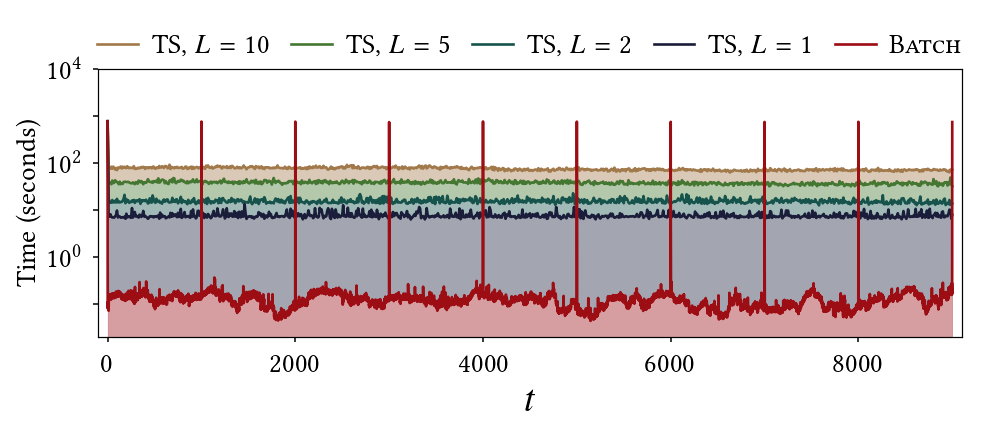

(9001, 21)
(9001, 21)
(9001, 21)
(9001, 21)
(9001, 21)


In [24]:
%matplotlib notebook

f, axarr = plt.subplots(1,1, figsize=(9,4))#, sharex=True, sharey='row')

dataset = "b_1dx100_s"
i = 0
for i,searcher in enumerate(selected_searcher): #searchers[:1]:
    sub = summary[(summary["searcherID"] == searcher) & (summary["refId"] == dataset)]
    
    print(sub.shape)
    
    if((searcher != 'SGMRD-KSP-0.9-All-1000-1000-0-1-1') & (searcher != 'SGMRD-KSP-0.9-None-1000-1-0-1-1')):
        toplot = sub["searchtime"].reset_index(drop=True) / 1000

        toplot = toplot[toplot != 0]
        
        sub_LOW = summary[(summary["searcherID"] == selected_searcher[i+1]) & (summary["refId"] == dataset)]
        
        if(selected_searcher[i+1] == 'SGMRD-KSP-0.9-All-1000-1000-0-1-1'):
            toplot_LOW = (sub_LOW["time"].reset_index(drop=True) / 1000)[::10]
        else: 
            toplot_LOW = sub_LOW["searchtime"].reset_index(drop=True) / 1000

        toplot_LOW = toplot_LOW[toplot_LOW != 0]
        
        toplot.plot(marker="", linestyle="-",
                    label=prettynames2[searcher], alpha=1, 
                        color=styledictionary2[prettynames2[searcher]]['color'])
        plt.fill_between(toplot.index, toplot_LOW, toplot, alpha=0.4,color=styledictionary2[prettynames2[searcher]]['color'],)

    else:
        toplot = sub["time"].reset_index(drop=True) / 1000

        toplot = toplot[toplot != 0]
        
        
        
        toplot.plot(linestyle="-", label=prettynames2[searcher], alpha=1,
                       color=styledictionary2[prettynames2[searcher]]['color'],
                       marker=styledictionary2[prettynames2[searcher]]['marker'])
        plt.fill_between(toplot.index, 0.001, toplot, alpha=0.4,color=styledictionary2[prettynames2[searcher]]['color'],)
    i += 1

plt.ylabel("Time (seconds)", fontsize=18)
plt.xlabel("$t$")
plt.yscale("log")
plt.ylim(0.02,10000)
plt.xlim(-100,9100)

plt.yticks([0.1,1,10,100,1000,10000], ["", "$10^0$", "", "$10^2$", "", "$10^4$"])

plt.legend(fontsize=18, loc="upper center", ncol=5, handletextpad=0.5, columnspacing=0.8, framealpha=0, handlelength=1.5,
          bbox_to_anchor=(0.50,1.22),)
plt.tight_layout(rect=[0, 0, 1, 0.90])

plt.savefig("plots/Figure12.pdf")

## Alternative

<IPython.core.display.Javascript object>


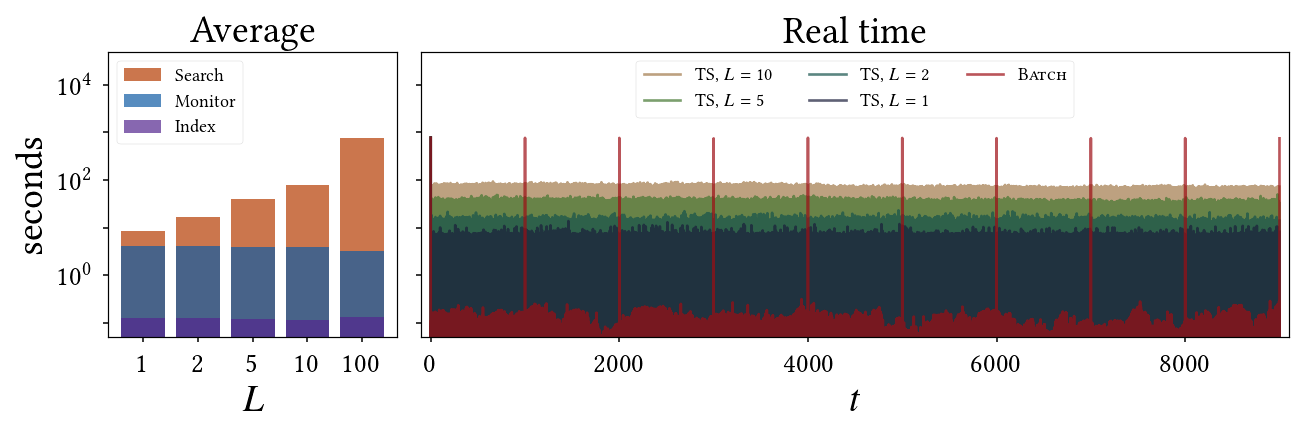

(10823, 21)
(10823, 21)
(10823, 21)
(10823, 21)
(10823, 21)


In [25]:
%matplotlib notebook

f, axarr = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 3]}, sharey=True)
axes = axarr.flatten()

plt.sca(axes[0])

toplot = subdata.groupby("L").mean().reset_index()
toplot["L"] = toplot["L"].astype(int)
toplot = toplot.sort_values("L")

plt.bar([i for i,x in enumerate(toplot["L"])], toplot["searchtime"]/1000, label="Search", color=oranges5[0],  alpha=0.7)
plt.bar([i for i,x in enumerate(toplot["L"])], toplot["monitortime"]/1000, label="Monitor", color=blues5[0],  alpha=0.7)
plt.bar([i for i,x in enumerate(toplot["L"])], toplot["indextime"]/1000, label="Index", color=purples5[0], alpha=0.7)
plt.xticks([i for i,x in enumerate(toplot["L"])], [1,2,5,10,100])
plt.legend(fontsize=12)
plt.yscale("log")
plt.ylim(0.05,10000)
plt.xlabel("$L$")
plt.ylabel("seconds")
plt.title("Average")
plt.tight_layout()

plt.sca(axes[1])

dataset = "b_1dx100_s"
i = 0
for searcher in selected_searcher: #searchers[:1]:
    sub = summary[(summary["searcherID"] == searcher) & (summary["refId"] == dataset)]
    print(subdata.shape)
    toplot = sub["time"].reset_index(drop=True) / 1000
    toplot[1::2] = 0
    #toplot = toplot[toplot != 0]
    if((searcher != 'SGMRD-KSP-0.9-All-1000-1000-0-1-1') & (searcher != 'SGMRD-KSP-0.9-None-1000-1-0-1-1')):
        toplot.plot(marker="", linestyle="-", ax=plt.gca(),
                    label=prettynames2[searcher], alpha=0.7, 
                        color=styledictionary2[prettynames2[searcher]]['color'])
    else:
        toplot.plot(linestyle="-", label=prettynames2[searcher], alpha=0.7,  ax=plt.gca(),
                       color=styledictionary2[prettynames2[searcher]]['color'],
                       marker=styledictionary2[prettynames2[searcher]]['marker'])
    i += 1

plt.title(r"Real time")
plt.yscale("log")
plt.ylim(0.05,50000)
plt.xlim(-100,9100)

plt.yticks([0.1, 1, 10, 100, 1000, 10000], ["", "$10^0$", "", "$10^2$", "", "$10^4$"])

plt.xlabel("$t$")

plt.legend(fontsize=12, loc="upper center", ncol=3)

plt.tight_layout()

#plt.savefig("runtime_search_monitor_index.pdf")